# Imports & Annotations

In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Set current working directory to parent folder
os.chdir(os.path.abspath(".."))

In [2]:
# Archivos importantes y paths
df_annotations = pd.read_excel('data/annotations.xlsx')

# Omitimos todos los audios en development
df_annotations = df_annotations[df_annotations['Type'] != 'Development'].reset_index(drop = True)

# Función anotaciones

In [3]:
def obtener_anotaciones(conversation, emocion):

    time = pd.DataFrame()

    df_file = df_annotations[(df_annotations['Emotion'] == emocion) & (df_annotations['Conversation_Part'] == conversation)]
    
    for annotation, annotator in zip(df_file['Annotation_File'], df_file['Annotator']):
        temp_df = pd.read_csv(f'data/MSPCORPUS/Annotations/{emocion}/{annotation}', skiprows=9, header=None, names=['Time', 'Annotation'])
        temp_df['Annotator'] = annotator
        time = pd.concat([time, temp_df], ignore_index = True)
    
    df_pivot = pd.DataFrame(time.pivot_table(columns = 'Annotator', index = 'Time', values = 'Annotation').to_records()).set_index('Time')
    df_pivot = df_pivot.fillna(method='ffill')
    df_pivot['Emotion'] = emocion
    df_pivot = df_pivot.reset_index()
    
    return df_pivot

# Investigación suavizado

In [4]:
from src.votaciones import votacion_promedio_ponderada, votacion_promedio_simple

In [5]:
# Json con pesos de anotadores
with open('data/pesos_anotadores_dif.json', 'r') as f:
    pesos_anotadores = json.load(f)

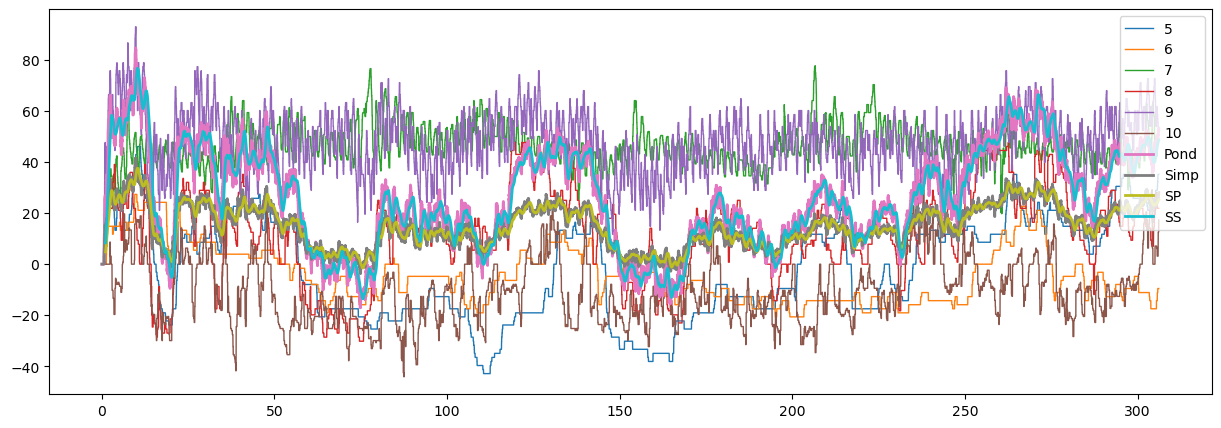

In [6]:
emocion = 'Arousal'
multiplicador = 10
part_num = 1
pc_num = '0021'

df_graf = obtener_anotaciones(f'MSP-Conversation_{pc_num}_{part_num}', emocion)

graficos = df_graf.drop(['Time','Emotion'], axis = 1).columns

df_simp = votacion_promedio_simple(df_annotations, part_num = part_num, pc_num = int(pc_num))
df_pond = votacion_promedio_ponderada(df_annotations, pesos_anotadores, part_num = part_num, pc_num = int(pc_num), multiplicador = multiplicador)

graficos = df_graf.drop(['Time','Emotion'], axis = 1).columns

plt.figure(figsize = (15,5))
for grafico in graficos:
    plt.plot(df_graf['Time'], df_graf[grafico], label = grafico, linewidth = 1)

plt.plot(df_pond['Time'], df_pond[emocion], label = 'Pond', linewidth = 2)
plt.plot(df_simp['Time'], df_simp[emocion], label = 'Simp', linewidth = 2)

df_simp[f'{emocion}_roll'] = df_simp[emocion].rolling(int(len(df_simp[emocion])/300)).mean()
df_pond[f'{emocion}_roll'] = df_pond[emocion].rolling(int(len(df_pond[emocion])/300)).mean()

plt.plot(df_pond['Time'], df_simp[f'{emocion}_roll'], label = 'SP', linewidth = 2)
plt.plot(df_simp['Time'], df_pond[f'{emocion}_roll'], label = 'SS', linewidth = 2)

plt.legend(loc = "upper right")
plt.xticks()
plt.show()

# Integración